# Overview of this jupyter notebook

1. Loading data
2. Data Preprocessing
<br>2.1 Creating train, val and test data
<br>2.2 Normalizing the data sets
3. CAE Hyperparameteroptimization
<br>3.1 Searching the optimal CAE structure with train reconstruction loss (MAE)
4.Searching optimal threshold through several methods
<br>4.1 Searching threshold with validation data
<br>4.2 Calculating threshold with mean and standard deviation
<br>4.3 Calculating threshold with max train error
5. Evaluation
<br>5.1 Evaluation with optimized threshold through validation data
<br>5.2 Evaluation with optimized threshold through standard deviation
<br>5.3 Evaluation with optimized threshold through max reconstrucion error

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
import pickle
import json
import random

In [3]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization, UpSampling1D
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
import os
import importlib
from library import faps_color as fapsc          # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
from library import autoencoder_helper as ah     #  this module contains helper functions for the anomaly detection task  
print(importlib.reload(fapsc))
print(importlib.reload(ch))
print(importlib.reload(ah))

<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>
<module 'library.autoencoder_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\autoencoder_helper.py'>


In [5]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


In [6]:
!python -V

Python 3.10.6


# 1. Loading data

In [7]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [9]:
feat_train = np.load("feature_label/occ_feature_train_v2.4.npy")
feature_train = np.zeros((feat_train.shape[0], 960))   # padding the curves 920 -> 960
feature_train[:,:feat_train.shape[1]] = feat_train
feature_train.shape

(2150, 960)

In [10]:
feat_test = np.load("feature_label/occ_feature_test_v2.4.npy")
feature_test = np.zeros((feat_test.shape[0], 960))   # padding the curves 920 -> 960
feature_test[:,:feat_test.shape[1]] = feat_test
feature_test.shape

(750, 960)

In [11]:
label_train = np.load("feature_label/occ_label_train_v2.4.npy")
label_train.shape

(2150, 8)

In [12]:
label_test = np.load("feature_label/occ_label_test_v2.4.npy")
label_test.shape

(750, 8)

# 2. Data Preprocessing

## 2.1 Creating train, val and test data

In [13]:
# using only curves from class 0 for x_train
# x_test contains 50 curves from each 15 classes

x_train = feature_train[:700]
x_test = feature_test

x_train.shape, x_test.shape

((700, 960), (750, 960))

In [15]:
# train_sector describes from which row feature_train each defect class begin

train_sector = np.array([750, 900, 1050, 1200, 1350, 1500, 1650, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150])
train_sector

array([ 750,  900, 1050, 1200, 1350, 1500, 1650, 1800, 1850, 1900, 1950,
       2000, 2050, 2100, 2150])

In [16]:
# 30 curves from class 0 and 5 curves of each defect class are saved in validation data to optimize the threshold 

x_val = feature_train[720:750]

for i in train_sector[:-1]:
    for j in range(5):
        x_val = np.append(x_val, [feature_train[i+10+j]], axis=0)

x_val.shape

(100, 960)

In [17]:
y_val = np.zeros(100).astype(int)
y_val[30:] = 1
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
y_train = (np.argmax(label_train, axis=1)>0).astype(int)
y_test = (np.argmax(label_test, axis=1)>0).astype(int)

In [19]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [20]:
(y_test==0).sum()

50

## 2.2 Normalizing the data sets

In [21]:
# normalize data by dividing through np.max(x_train)

max_train = np.max(x_train)
min_train = np.min(x_train)
x_train_scaled = x_train / max_train
x_test_scaled = x_test / max_train
x_val_scaled = x_val / max_train

min_train, max_train

(0.0, 2.62528)

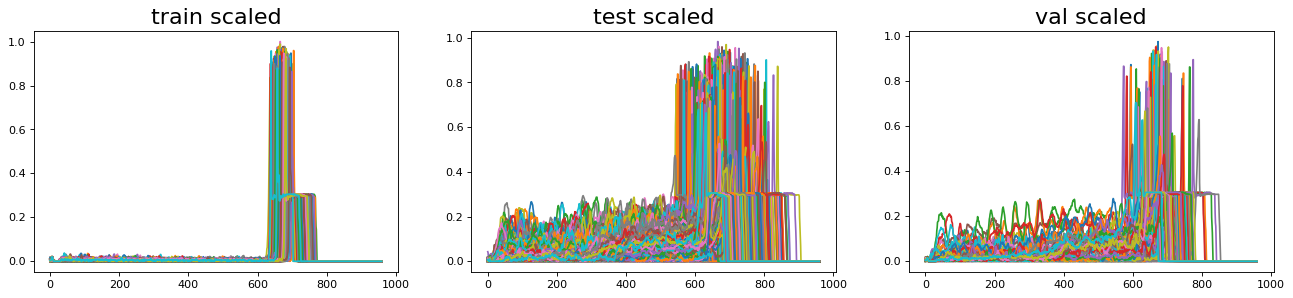

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20,4), dpi=80)
axs[0].plot(x_train_scaled.transpose())
axs[1].plot(x_test_scaled.transpose())
axs[2].plot(x_val_scaled.transpose())

axs[0].set_title("train scaled", fontsize=20)
axs[1].set_title("test scaled", fontsize=20)
axs[2].set_title("val scaled", fontsize=20)
fig.show()

In [23]:
x_train_inverse = x_train_scaled * max_train
x_test_inverse = x_test_scaled * max_train
x_val_inverse = x_val_scaled * max_train

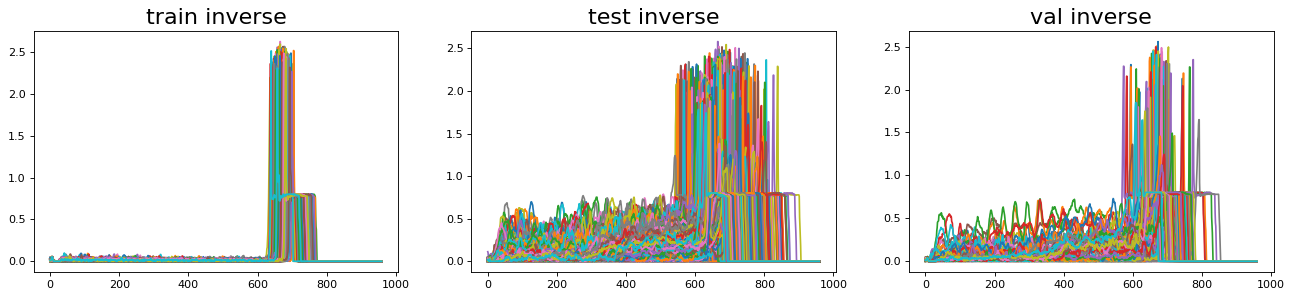

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20,4), dpi=80)
axs[0].plot(x_train_inverse.transpose())
axs[1].plot(x_test_inverse.transpose())
axs[2].plot(x_val_inverse.transpose())

axs[0].set_title("train inverse", fontsize=20)
axs[1].set_title("test inverse", fontsize=20)
axs[2].set_title("val inverse", fontsize=20)
fig.show()

In [25]:
# check, whether the inverse data is equal to original data

np.array_equal(np.round(x_train, 4), np.round(x_train_inverse, 4))

True

In [26]:
# reshape train and test data in 3 dim data for CNN AutoEncoder
len_curve = 960

x_train = x_train.reshape(-1, len_curve, 1)
x_test = x_test.reshape(-1, len_curve, 1)
x_val = x_val.reshape(-1, len_curve, 1)

x_train_scaled = x_train_scaled.reshape(-1, len_curve, 1)
x_test_scaled = x_test_scaled.reshape(-1, len_curve, 1)
x_val_scaled = x_val_scaled.reshape(-1, len_curve, 1)

In [27]:
x_val_scaled.shape

(100, 960, 1)

# 3. CAE Hyperparameteroptimization 

## 3.1 Searching the optimal CAE structure with train reconstruction loss (MAE)

In [29]:
def cae(conv, filters, kernel, strides, lr):
    
    model = Sequential()
    # encoder
    if conv >= 1:
        model.add(Conv1D(filters, kernel, strides=strides, activation="relu", padding='same', input_shape=(len_curve, 1)))
    if conv >= 2:
        model.add(Conv1D(filters, kernel, strides=strides, activation="relu", padding='same'))    
    if conv >= 3:
        model.add(Conv1D(filters, kernel, strides=strides, activation="relu", padding='same'))

    if conv >= 4:
        model.add(Conv1D(filters, kernel, strides=strides, activation="relu", padding='same'))

    
    #decoder
    if conv >= 1:
        model.add(Conv1DTranspose(filters, kernel, strides=strides, activation="relu", padding='same'))
    if conv >= 2:
        model.add(Conv1DTranspose(filters, kernel, strides=strides, activation="relu", padding='same'))
    if conv >= 3:
        model.add(Conv1DTranspose(filters, kernel, strides=strides, activation="relu", padding='same'))
    if conv >= 4:
        model.add(Conv1DTranspose(filters, kernel, strides=strides, activation="relu", padding='same'))
    
    model.add(Conv1DTranspose(1, kernel, activation='sigmoid', padding= 'same'))
    
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["mae"])
    print(model.summary())
    return model

In [27]:
from itertools import product

conv = [2,3,4]
filters = [16,32,48]
kernel = [4,8,16]
strides=[1,2,4]
lr = [0.001, 0.005, 0.01]
batch_size = [4, 16, 32]

paramcom = product(conv, filters, kernel, strides, lr, batch_size)

In [ ]:
result_dict = {"conv_layer":[], "filters":[], "kernel":[], "strides":[], "learning_rate":[], "batch_size":[],
                       "mean_rmse":[], "mean_mae":[], "mean_mse":[]} 

In [ ]:
# grid search to find the optimal hyperparameters for the cae

for i, com in enumerate(paramcom):
    print(f"start {i}th combination: {com}")
    try:
        model = cae(conv=com[0], filters=com[1], kernel=com[2], strides=com[3], lr=com[4])
        history = model.fit(x_train_scaled, x_train_scaled, epochs=200, batch_size=com[5], validation_split=0.2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

        reconstructed_train_inverse = ah.reconstruct_curves(model, x_train_scaled, max_train, len_curve, scaled=True)
        rmse, mae, mse = ah.calc_reconstruction_loss(x_train_inverse, reconstructed_train_inverse)
        print(rmse, mae, mse)

        
        result_file_name = "occ_cae_hyperopt_v2.4.1.json"

        if os.path.exists(f"results/{result_file_name}") == False:
            with open(f"results/{result_file_name}", "w") as f:
                json.dump(result_dict, f)
                f.close()
        else: 
            with open(f"results/{result_file_name}", "r") as f:
                file = json.load(f)
                file["conv_layer"].append(com[0])
                file["filters"].append(com[1])
                file["kernel"].append(com[2])
                file["strides"].append(com[3])
                file["learning_rate"].append(com[4])
                file["batch_size"].append(com[5])
                file["mean_rmse"].append(rmse)
                file["mean_mae"].append(mae)
                file["mean_mse"].append(mse)

            with open(f"results/{result_file_name}", "w") as f:
                json.dump(file, f)
                f.close()

        print(f"end {i}th combination: {com}")
    
    except:
        pass

In [30]:
with open("results/occ_cae_hyperopt_v2.4.1.json", "r") as f:
    res = json.load(f)

In [31]:
df_res = pd.DataFrame(res)
df_res

,conv_layer,filters,kernel,strides,learning_rate,batch_size,mean_rmse,mean_mae,mean_mse
0,2,16,4,1,0.001,16,0.005783,0.003008,0.000034
1,2,16,4,1,0.001,32,0.004993,0.002029,0.000026
2,2,16,4,1,0.005,4,0.015302,0.003507,0.000251
3,2,16,4,1,0.005,16,0.006225,0.001786,0.000041
4,2,16,4,1,0.005,32,0.004046,0.001135,0.000018
...,...,...,...,...,...,...,...,...,...
642,4,48,16,2,0.005,16,0.027592,0.006893,0.000843
643,4,48,16,2,0.005,32,0.017033,0.005097,0.000315
644,4,48,16,2,0.010,4,0.019875,0.005158,0.000432
645,4,48,16,2,0.010,16,0.228680,0.113603,0.052307


In [32]:
df_res.sort_values(by=["mean_mae"], ascending=True)

,conv_layer,filters,kernel,strides,learning_rate,batch_size,mean_rmse,mean_mae,mean_mse
80,2,32,4,1,0.001,4,0.001277,0.000357,0.000002
81,2,32,4,1,0.001,16,0.001610,0.000434,0.000003
188,2,48,8,1,0.001,4,0.001625,0.000442,0.000003
89,2,32,4,2,0.001,4,0.002047,0.000504,0.000004
405,3,48,4,1,0.001,16,0.001773,0.000519,0.000003
...,...,...,...,...,...,...,...,...,...
645,4,48,16,2,0.010,16,0.228680,0.113603,0.052307
317,3,16,16,4,0.005,4,0.229562,0.113697,0.052711
579,4,32,16,1,0.005,16,0.231162,0.114049,0.053448
634,4,48,16,1,0.005,32,0.232291,0.115428,0.053971


In [34]:
final_model = cae(conv=2, filters=32, kernel=4, strides=1, lr=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 960, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 960, 32)           4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 960, 32)          4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 960, 32)          4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 960, 1)           129       
 ranspose)                                                       
                                                        

In [35]:
history = final_model.fit(x_train_scaled, x_train_scaled, epochs=200, batch_size=4, validation_split=0.2,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

Epoch 1/200
140/140 [==============================] - 10s 9ms/step - loss: 0.1556 - mae: 0.0774 - val_loss: 0.0597 - val_mae: 0.0038
Epoch 2/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0592 - mae: 0.0035 - val_loss: 0.0592 - val_mae: 0.0033
Epoch 3/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0588 - mae: 0.0030 - val_loss: 0.0587 - val_mae: 0.0025
Epoch 4/200
140/140 [==============================] - 1s 6ms/step - loss: 0.0583 - mae: 0.0024 - val_loss: 0.0583 - val_mae: 0.0022
Epoch 5/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0580 - mae: 0.0020 - val_loss: 0.0581 - val_mae: 0.0017
Epoch 6/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0579 - mae: 0.0018 - val_loss: 0.0580 - val_mae: 0.0017
Epoch 7/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0578 - mae: 0.0016 - val_loss: 0.0580 - val_mae: 0.0015
Epoch 8/200
140/140 [==============================] - 1s 6ms/step -

140/140 [==============================] - 1s 8ms/step - loss: 0.0571 - mae: 4.0126e-04 - val_loss: 0.0573 - val_mae: 1.8556e-04
Epoch 118/200
140/140 [==============================] - 1s 8ms/step - loss: 0.0571 - mae: 2.2859e-04 - val_loss: 0.0573 - val_mae: 2.6739e-04
Epoch 119/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0571 - mae: 2.0060e-04 - val_loss: 0.0573 - val_mae: 2.0101e-04
Epoch 120/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0571 - mae: 2.5881e-04 - val_loss: 0.0573 - val_mae: 3.1998e-04
Epoch 120: early stopping


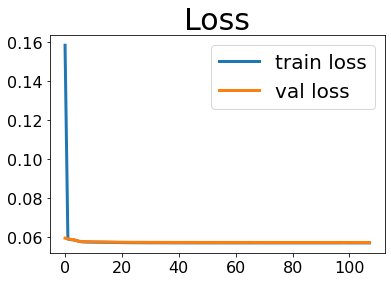

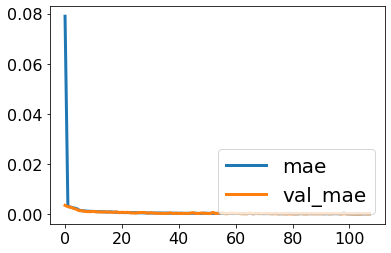

In [40]:
ch.plot_history(history)

In [81]:
#final_model.save("model/occ_cae_v2.4.1.h5")

In [86]:
#with open("model/history_occ_cae_v2.4.1.json", "w") as f:
    json.dump(history.history, f)
    f.close()

In [28]:
final_model = load_model("model/occ_cae_v2.4.1.h5")

# 4. Searching optimal threshold through several methods

## 4.1 Searching threshold with validation data

In [29]:
#print(importlib.reload(ah))

reconstructed_train_inverse = ah.reconstruct_curves(final_model, x_train_scaled, max_train, len_curve, scaled=True)
reconstructed_val_inverse = ah.reconstruct_curves(final_model, x_val_scaled, max_train, len_curve, scaled=True)

reconstructed_curves_inverse shape: (700, 960)
reconstructed_curves_inverse shape: (100, 960)


In [30]:
train_mae = ah.calc_mae(x_train_inverse, reconstructed_train_inverse)
val_mae = ah.calc_mae(x_val_inverse, reconstructed_val_inverse)

In [31]:
print(importlib.reload(ah))

<module 'library.autoencoder_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\autoencoder_helper.py'>


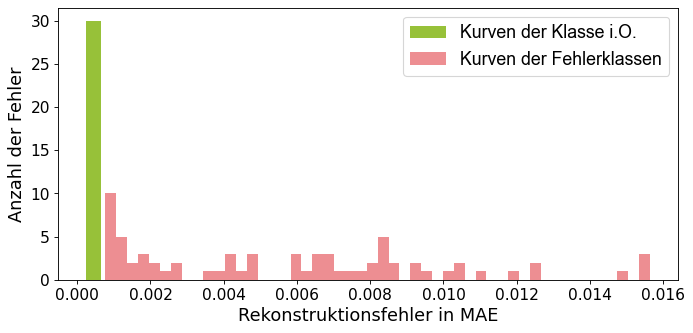

In [32]:
ah.plot_clean_fraud(y_test=y_val, test_error=val_mae, bin_num0=1, bin_num1=50, bin_width0=0.0004, figsize=(10,4.5), dpi=80)

In [31]:
#pd.set_option('display.max_rows', 2000)

In [33]:
# iterate threshold to calculate tpr and fpr for ROC-curve

start = 0.0
end = 0.02
steps = 0.00001

val_threshold = {"threshold": [], "tpr": [], "fpr": [], "f1": [], "acc": []}

for i in np.arange(start, end, steps):
    val_threshold["threshold"].append(i)
    tpr, fpr, f1, acc, cm = ah.get_preds(y_val, threshold=i, loss=val_mae)
    val_threshold["tpr"].append(tpr)
    val_threshold["fpr"].append(fpr)
    val_threshold["f1"].append(f1)
    val_threshold["acc"].append(acc)

In [34]:
df_threshold = pd.DataFrame(val_threshold)
df_threshold

,threshold,tpr,fpr,f1,acc
0,0.00000,1.0,1.0,0.823529,0.7
1,0.00001,1.0,1.0,0.823529,0.7
2,0.00002,1.0,1.0,0.823529,0.7
3,0.00003,1.0,1.0,0.823529,0.7
4,0.00004,1.0,1.0,0.823529,0.7
...,...,...,...,...,...
1995,0.01995,0.0,0.0,0.000000,0.3
1996,0.01996,0.0,0.0,0.000000,0.3
1997,0.01997,0.0,0.0,0.000000,0.3
1998,0.01998,0.0,0.0,0.000000,0.3


In [35]:
df_threshold[df_threshold.f1==1]["threshold"].min()

0.0005600000000000001

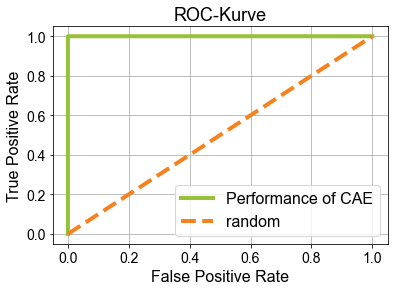

In [36]:
plt.figure(figsize=(6,4))
plt.plot(df_threshold["fpr"], df_threshold["tpr"], color=fapsc.green, linewidth=4, label="Performance of CAE")
plt.plot([0, 1], [0, 1], color=fapsc.orange, linewidth=4, linestyle="--", label="random")

plt.xlabel("False Positive Rate", fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel("True Positive Rate", fontsize=16)
plt.yticks(fontsize=14)
plt.title("ROC-Kurve", fontsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.grid()
plt.show()

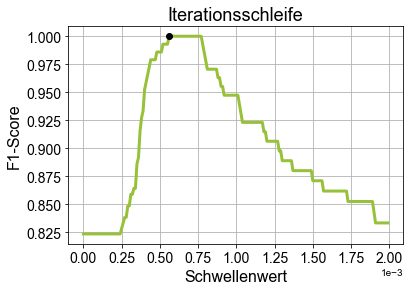

In [37]:
plt.figure(figsize=(6,4))
plt.plot(df_threshold["threshold"][:200], df_threshold["f1"][:200], linewidth=3, color=fapsc.green, label="F1-Score")
plt.scatter(df_threshold[df_threshold.f1==1]["threshold"].min(), 1, color=fapsc.black).set_zorder(2)

plt.xlabel("Schwellenwert", fontsize=16)
plt.ylabel("F1-Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Iterationsschleife", fontsize=18)
#plt.legend(loc="upper right", fontsize=16)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,2))
plt.grid()
plt.show()

In [38]:
threshold1 = df_threshold[df_threshold.f1==1]["threshold"].min()
threshold1

0.0005600000000000001

## 4.2 Calculating threshold with mean and standard deviation

In [39]:
threshold2 = np.mean(train_mae) + 3*np.std(train_mae)
threshold2

0.0005599672083340761

##  4.3 Calculating threshold with max train error

In [40]:
threshold3 = max(train_mae)
threshold3

0.0006935510453884697

In [40]:
print(importlib.reload(ah))

<module 'library.autoencoder_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\autoencoder_helper.py'>


# 5. Evaluation

In [41]:
reconstructed_train_inverse, reconstructed_test_inverse = ah.prepare_train_test(final_model, x_train_scaled, x_test_scaled, 
                                                                                max_train, len_curve=x_train.shape[1], 
                                                                                scaled=True)

reconstructed_train_inverse shape: (700, 960)
reconstructed_test_inverse shape: (750, 960)


In [42]:
train_mae = ah.calc_mae(x_train_inverse, reconstructed_train_inverse)
test_mae = ah.calc_mae(x_test_inverse, reconstructed_test_inverse)

## 5.1 Evaluation with optimized threshold through validation data

In [43]:
rec1, pre1, f1_1, acc1, anomaly_prediction1 = ah.get_anomaly_pred_acc(y_test, threshold=threshold1, loss=test_mae)
anomaly_prediction1

Recall: 1.0
Precision: 1.0
F1 Score: 1.0
Accuracy: 1.0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

<module 'library.autoencoder_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\autoencoder_helper.py'>


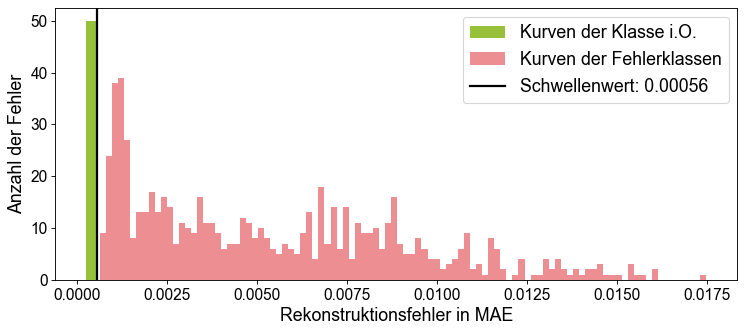

In [44]:
print(importlib.reload(ah))
ah.plot_clean_fraud(y_test=y_test, test_error=test_mae, bin_num0=1, bin_num1=100, bin_width0=0.0003,
                    threshold=np.round(threshold1, 6), figsize=(11,4.5), dpi=80)

In [45]:
res1 = ch.collect_results_occ(y_test, anomaly_prediction1, algorithm="cae", params=None, 
                            best_param="threshold_val", cm=confusion_matrix(y_test, anomaly_prediction1).tolist())
res1

{'algorithm': 'cae',
 'params': None,
 'best_param': 'threshold_val',
 'cm': [[50, 0], [0, 700]],
 'rec': 1.0,
 'pre': 1.0,
 'f1': 1.0,
 'acc': 1.0}

In [46]:
#ch.save_results_json(filename="occ_hyperopt_results_v2.4.1.json", 
                     key_algorithm = "cae_val", 
                     hyperopt_result = res1)

existing file occ_hyperopt_results_v2.4.1.json opened and results of cae_val saved.


## 5.2 Evaluation with optimized threshold through standard deviation

In [45]:
rec2, pre2, f1_2, acc2, anomaly_prediction2 = ah.get_anomaly_pred_acc(y_test, threshold=threshold2, loss=test_mae)
anomaly_prediction2

Recall: 1.0
Precision: 1.0
F1 Score: 1.0
Accuracy: 1.0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [49]:
res2 = ch.collect_results_occ(y_test, anomaly_prediction2, algorithm="cae", params=None, 
                            best_param="threshold_std", cm=confusion_matrix(y_test, anomaly_prediction2).tolist())
res2

{'algorithm': 'cae',
 'params': None,
 'best_param': 'threshold_std',
 'cm': [[50, 0], [0, 700]],
 'rec': 1.0,
 'pre': 1.0,
 'f1': 1.0,
 'acc': 1.0}

In [50]:
#ch.save_results_json(filename="occ_hyperopt_results_v2.4.1.json", 
                     key_algorithm = "cae_std", 
                     hyperopt_result = res2)

existing file occ_hyperopt_results_v2.4.1.json opened and results of cae_std saved.


## 5.3 Evaluation with optimized threshold through max reconstrucion error

In [46]:
rec3, pre3, f1_3, acc3, anomaly_prediction3 = ah.get_anomaly_pred_acc(y_test, threshold=threshold3, loss=test_mae)
anomaly_prediction3

Recall: 0.9971428571428571
Precision: 1.0
F1 Score: 0.9985693848354792
Accuracy: 0.9973333333333333


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [52]:
res3 = ch.collect_results_occ(y_test, anomaly_prediction3, algorithm="cae", params=None, 
                              best_param="threshold_max", cm=confusion_matrix(y_test, anomaly_prediction3).tolist())
res3

{'algorithm': 'cae',
 'params': None,
 'best_param': 'threshold_max',
 'cm': [[50, 0], [2, 698]],
 'rec': 0.9971428571428571,
 'pre': 1.0,
 'f1': 0.9985693848354792,
 'acc': 0.9973333333333333}

In [53]:
#ch.save_results_json(filename="occ_hyperopt_results_v2.4.1.json", 
                     key_algorithm = "cae_max", 
                     hyperopt_result = res3)

existing file occ_hyperopt_results_v2.4.1.json opened and results of cae_max saved.
